# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(randomForest)
library(qs)
library(parallel)
library(igraph)
library(ggraph)
library(inTrees)
library(RRF)
library(clustermq)
library(viridis)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomFore

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] endoR_0.1.0         viridis_0.5.1       viridisLite_0.3.0  
 [4] clustermq_0.8.95.1  RRF_1.9.1           inTrees_1.3        
 [7] ggraph_2.0.4        igraph_1.2.6        qs_0.23.4          
[10] randomForest_4.6-14 data.table_1.13.4   caret_6.0-86     

## functions

In [3]:
file.sources <- list.files('../scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Data

In [4]:
meta <- c('dataset','Sample','age','gender','country','BMI','westernized', 'number_reads')

In [5]:
rules <- qread('../tmp/ruleExec_full.qs')
related_taxa <- qread('../tmp/related_taxa_full.qs')
X <- qread('../tmp/X.qs')

In [6]:
is_s <- str_which(names(related_taxa), pattern = '^s_')
related_taxa[is_s] <- related_taxa[is_s] %>% lapply(function(x){str_subset(x, pattern = '^s|g')})
related_taxa$groupa <- 'groupa'
related_taxa$groupb <- 'groupb'
related_taxa$groupc <- 'groupc'
related_taxa$groupd <- 'groupd'

In [7]:
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/', full.names = TRUE, recursive = TRUE
                    )%>% str_subset(pattern = 'B100/')


In [8]:
res <- qread(fnames[5])
fnames[5]

[1] "/ebio/abt3_projects/temp_data/aruaud/MtgSimu50//p005_B100/simu155_p0_05.qs"

# B=100 

## get

In [9]:
n_cores <- 30
tmpl <- list(conda = "r-ml", cores = n_cores, job_time = '24:00:00', job_mem = '20G')

In [14]:
simu <- Q(wrappy, fail_on_error = TRUE
  , seedN = 1:10
  , const=list(rf_fs = res$rf, target = res$target, data = res$data
               ,times = 100, p=0.5
               , discretize = TRUE, K = 2, prune = TRUE
               , in_parallel = TRUE, n_cores = n_cores
               , path = '/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/p005_B100-10same_5/'
              )
  , n_jobs= 10
  , pkgs=c('data.table', 'randomForest'
           , 'parallel', 'caret', 'stringr', 'scales', 'dplyr', 'inTrees'
           , 'babR', 'qs', 'RRF', 'tidyverse')
  , log_worker=FALSE
  , template = tmpl
 )

Warning message in (function (...) :
“Common data is 7.5 Mb. Recommended limit is  (set by clustermq.data.warning option)”
Submitting 10 worker jobs (ID: cmq6164) ...

Running 10 calculations (11 objs/7.5 Mb common; 1 calls/chunk) ...


[---------------------------------------------------]   0% (1/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (2/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (3/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (4/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (5/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (6/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (7/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (8/10 wrk) eta:  ?s

[---------------------------------------------------]   0% (9/10 wrk) eta:  ?s

[------------------------------------------

## aggregate b=100

In [10]:
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/p005_B100-10same_5/', full.names = TRUE, recursive = TRUE)

In [11]:
res_b100 <- list()

for (i in 1:10){
    res_b100[[i]] <- res
    res_b100[[i]]$resampled <- qread(fnames[i])
}

# Results b=10

In [12]:
res_b10 <- list()

for (i in 0:9){
    res_b10[[i+1]] <- res
    res_b10[[i+1]]$resampled <- res_b10[[i+1]]$resampled[(i*10 + 1):((i+1)*10)]
}

# get curves

In [13]:
#stopCluster(cluster)
cluster <- makeCluster(7)
quiet(clusterEvalQ(cluster, library(qs)))
quiet(clusterEvalQ(cluster, library(endoR)))
quiet(clusterEvalQ(cluster, library(tidyverse)))
quiet(clusterExport(cluster, c('getSinglePR_singleB', 'metricsNet', 'quiet' )))

In [14]:
b10_curves <- parLapply(cl = cluster, res_b10, getPR_singleB, alpha = 5, pi_thr = 0.7, related_taxa=related_taxa
                     , all = (525^2-525)/2)

In [15]:
b100_curves <- parLapply(cl = cluster, res_b100, getPR_singleB, alpha = 5, pi_thr = 0.7, related_taxa=related_taxa
                     , all = (525^2-525)/2)

In [16]:
stopCluster(cluster)

In [17]:
b10_curves <- lapply(1:length(b10_curves), function(i,x){x[[i]]$rep <- i;return(x[[i]])}, x = b10_curves)
b10_curves <- do.call(rbind, b10_curves)

In [18]:
b100_curves <- lapply(1:length(b100_curves), function(i,x){x[[i]]$rep <- i;return(x[[i]])}, x = b100_curves)
b100_curves <- do.call(rbind, b100_curves)

In [19]:
b_curves <- rbind(b10_curves, b100_curves)
b_curves$rep <- paste0(b_curves$B, '_', b_curves$rep)

In [20]:
suppressWarnings(b_av <- b_curves %>% select(-rep) %>% group_by(B, inN) %>% summarise_all(mean))

# interpolate

In [21]:
b_byrep <- suppressWarnings(lapply(unique(b_curves$rep), getInterpo, raw = b_curves))

In [22]:
b_byrep_av <- do.call(rbind, b_byrep) %>% select(-rep) %>% group_by(fp, B) %>% summarise_all(mean)
b_byrep_sd <- do.call(rbind, b_byrep) %>% select(-rep) %>% group_by(fp, B) %>% summarise_all(sd)

a10_forplots <- left_join(b_byrep_av, b_byrep_sd, by = c('fp', 'B'), suffix = c('_av', '_sd'))

# plots

In [23]:
b_av$B <- factor(b_av$B, levels = c('10', '100'))
a10_forplots$B <- factor(a10_forplots$B, levels = c('10', '100'))

In [24]:
cols <- plasma(length(unique(b_av$B)) + 2)

In [25]:
p <- ggplot(a10_forplots %>% subset(fp < 100)
             , aes(x = fp, y = tp_av, group = B, color = as.factor(B)))+

geom_hline(yintercept = 9, color = 'lightgrey', linetype = 'dashed')+

geom_line(size = 1)+

geom_ribbon(aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group = B, fill = as.factor(B)), color = NA
            , alpha = 0.3) +
geom_ribbon(data = a10_forplots %>% subset(fp < 100 & B == 100)
            , aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group = B, fill = as.factor(B)), color = NA
            , alpha = 0.4) +


geom_point(data = b_av %>% subset((B == '10' & inN == 7) | (B == '100' & inN == 70))
           , aes(y = tp, x = fp, fill = as.factor(B))
           , size = 4, shape = 21, color = 'black')+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP') +
scale_color_manual(values = cols[-c(1, length(cols))], name = 'B') +
scale_fill_manual(values = cols[-c(1, length(cols))], name = 'B')


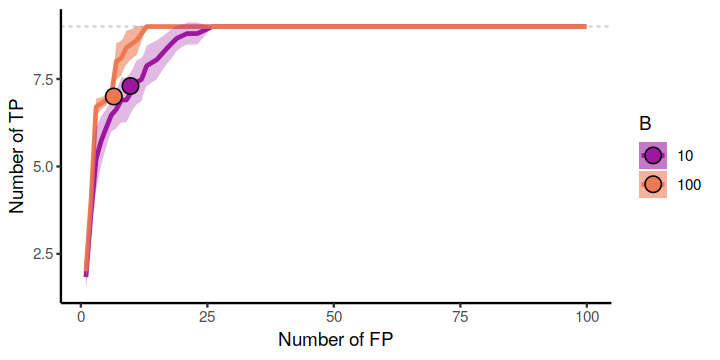

In [26]:
options(repr.plot.width=6, repr.plot.height=3)
p